<a href="https://colab.research.google.com/github/ajain625/ML_experiements/blob/main/Income_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is my attempt at building an object detector using a small sample of the ADULT (provided by UCI) database. I have used FastAI (a library built on top of PyTorch) and SciKit to achieve this. The sample considered has demographic information of various adults in the USA and whether their annual income exceeds 50K.

I have been able to achieve 84% accuracy using random forests and a neural net seperately.

There is also a cell showing the most important feautures in the random forest approach to make the prediction.

In [1]:
!pip install -Uqq fastbook

     |████████████████████████████████| 720 kB 5.0 MB/s 
     |████████████████████████████████| 1.2 MB 8.4 MB/s 
     |████████████████████████████████| 189 kB 12.1 MB/s 
     |████████████████████████████████| 48 kB 1.8 MB/s 
     |████████████████████████████████| 55 kB 1.5 MB/s 
     |████████████████████████████████| 558 kB 37.8 MB/s 
     |████████████████████████████████| 51 kB 102 kB/s 
     |████████████████████████████████| 130 kB 20.4 MB/s 


In [2]:
import fastbook
fastbook.setup_book()
from fastbook import *

Mounted at /content/gdrive


In [5]:
path = untar_data(URLs.ADULT_SAMPLE)
Path.BASE_PATH = path
df = pd.read_csv(path/'adult.csv', low_memory = False)
df.salary = (df.salary == '>=50k')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32561 non-null  int64  
 1   workclass       32561 non-null  object 
 2   fnlwgt          32561 non-null  int64  
 3   education       32561 non-null  object 
 4   education-num   32074 non-null  float64
 5   marital-status  32561 non-null  object 
 6   occupation      32049 non-null  object 
 7   relationship    32561 non-null  object 
 8   race            32561 non-null  object 
 9   sex             32561 non-null  object 
 10  capital-gain    32561 non-null  int64  
 11  capital-loss    32561 non-null  int64  
 12  hours-per-week  32561 non-null  int64  
 13  native-country  32561 non-null  object 
 14  salary          32561 non-null  bool   
dtypes: bool(1), float64(1), int64(5), object(8)
memory usage: 3.5+ MB


In [6]:
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier

In [7]:
procs = [Categorify, FillMissing]
cat = ['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'native-country']
cont = ['age', 'hours-per-week', 'fnlwgt', 'education-num']
dep_var = 'salary'
split = RandomSplitter(valid_pct = 0.2, seed = 42)(range_of(df))
adultData = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=split)

In [9]:
n_estimators = 40 #Number of Trees
max_samples = 10000 #Number of entries to consider per tree
max_features = 0.5 #Proportion of available features to use for training each tree
min_samples_leaf = 15 #Minimum Samples that each leaf in each tree must have

rf_model = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(adultData.train.xs, adultData.train.y)

In [10]:
rf_model.oob_score_

0.8369227225613267

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix

valid_accuracy, training_accuracy = accuracy_score(adultData.valid.y, rf_model.predict(adultData.valid.xs)), accuracy_score(adultData.train.y, rf_model.predict(adultData.train.xs))

TN, FP, FN, TP = confusion_matrix(adultData.valid.y, rf_model.predict(adultData.valid.xs)).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)
print('Training Accuracy = ', training_accuracy)
print('Valid Accuracy = ', valid_accuracy)

True Positive(TP)  =  863
False Positive(FP) =  354
True Negative(TN)  =  4599
False Negative(FN) =  696
Training Accuracy =  0.8502053821643825
Valid Accuracy =  0.8387592137592138


In [ ]:
predictions = np.stack([m.predict(adultData.valid.xs) for m in rf_model.estimators_])

(40, 6512)


Text(0, 0.5, 'Accuracy')

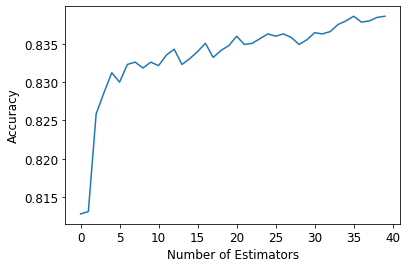

In [14]:
#This plots how the accuracy varies as the number of trees considered increases. Used to identify appropriate value for the n_estimators feature
print(predictions.shape)
plt.plot([accuracy_score(adultData.valid.y, predictions[:i+1].mean(0)>0.5) for i in range(40)])
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')

In [16]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

rf_feat_importance(rf_model, adultData.train.xs)

,cols,imp
3,relationship,0.347564
11,education-num,0.227017
8,age,0.154613
9,hours-per-week,0.076781
10,fnlwgt,0.060152
2,occupation,0.048995
1,education,0.041868
0,workclass,0.018621
5,sex,0.018519
4,race,0.002786


Neural Netowrk using FastAI's Tabular Learner

In [17]:
cat_nn = ['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'hours-per-week', 'education-num']
cont_nn = ['age', 'fnlwgt']
dep_var = ['salary']
df.salary = df.salary.astype(float)
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df, procs_nn, cat_nn, cont_nn,
                      splits=split, y_names=dep_var)

In [18]:
dls = to_nn.dataloaders(1024)
learn = tabular_learner(dls, y_range = (0,1), layers=[200,100],
                        n_out=1, loss_func = nn.BCELoss())

In [19]:
learn.fit_one_cycle(8, 1e-3)

epoch,train_loss,valid_loss,time
0,0.628359,0.738407,00:00
1,0.561921,0.546323,00:00
2,0.508695,0.435969,00:00
3,0.470016,0.395625,00:00
4,0.440062,0.407230,00:00
5,0.416245,0.393198,00:00
6,0.398972,0.385393,00:00
7,0.387337,0.384391,00:00


In [22]:
preds,targs = learn.get_preds()
accuracy_score(targs, preds>0.5)

0.8358415233415234